In [1]:
from scipy.integrate import odeint

import numpy as np
import numpy.random as rd

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import pandas as pd

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn

import seaborn as sns

In [2]:
%matplotlib inline

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

In [3]:
import warnings
warnings.filterwarnings("error")

In [4]:
rd.seed(seed=1)

## Ground Truth Generation

This section generates the database used for the learning.

Container's height is defined in the _toTest_ variable. In this case, there is only one tested, fixed on 3.

In [5]:
toTest = [3]

In [6]:
def fillingTank(y, t, R, maxH, qin):
    h, q = y
    dydt = [ 0 if h > maxH else q/(3.14*R**2),
             -q*h/maxH ]
    
    return(dydt)

def simuleMaxH( t, qin, R, maxH ):
    sol = odeint(fillingTank, [0,qin], t, args=(R,maxH,qin))
    
    h = sol[:,0]
    v = sol[:,0]*3.14*R**2
    q = np.array([ sol[i,1] if h[i]<maxH else 0 for i in range(len(h))])
    return(h, v, q)

### Generate Dataset

In [7]:
T = 5
maxT = 100
t = np.linspace(0,T,maxT)
R = 1
qin = 10

nbRep = 1000
skip = True

d = { "Time":[], "Time Steps":[],
     "H":[], "dH":[], "V":[], "dV":[], "Q":[], "dQ":[], "MaxH":[], "R":[], "Qin":[], "Dataset":[] }

for maxH in toTest:
    rep = 0
    while rep < nbRep:
        warning = True
        try:
            qin = rd.normal(10,1)
            R = rd.normal(1,0.)
            h, v, q = simuleMaxH( t, qin, R, maxH )
            warning = False
        except:
            pass
        
        if not warning:
            if not skip:
                plt.plot(t, h, label = "h")
                plt.plot(t, v, label = "v")
                plt.plot(t, q, label = "q")
                plt.plot([0,T], [maxH,maxH], "--")

                plt.title(f"{rep} - Max Height = {maxH} - R = {R} - Q = {qin}")
                plt.legend()
                plt.show()

            d["Time"] += t.tolist()
            d["Time Steps"] += list(range(1, len(t)+1))

            d["H"] += h.tolist()
            d["dH"] += list( np.hstack((h[1:],h[-1]))-h )

            d["V"] += v.tolist()
            d["dV"] += list( np.hstack((v[1:],v[-1]))-v )

            d["Q"] += q.tolist()
            d["dQ"] += list( np.hstack((q[1:],q[-1]))-q )

            d["MaxH"] += [maxH for k in t]
            d["R"] += [R for k in t]
            d["Qin"] += [qin for k in t]
            d["Dataset"] += [rep for k in t]
            
            rep += 1
    
df = pd.DataFrame(d)

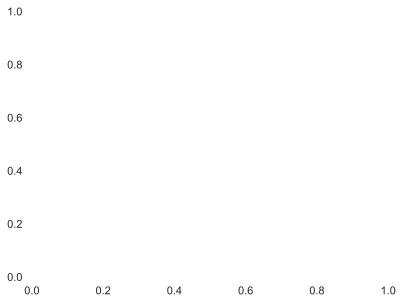

In [8]:
fig, ax = plt.subplots()

d_time = { "FinalTime":[], "H":[], "MaxH":[], "i":[], "Time Steps":[] }
for maxH in toTest:
    Y = df[ df["MaxH"] == maxH ]
    
    for d in set(Y["Dataset"]):
        X = Y[ Y["Dataset"] == d ]
        
        i = X[ maxH - X["H"] < 1e-10 ].index[0]
        
        d_time[ "i" ].append( i )
        d_time[ "FinalTime" ].append( X.loc[i, "Time"] )
        d_time[ "H" ].append( X.loc[i,"H"] )
        d_time[ "MaxH" ].append( maxH )
        d_time[ "Time Steps" ].append( X.loc[i, "Time Steps"] )
        
df_time = pd.DataFrame( d_time )

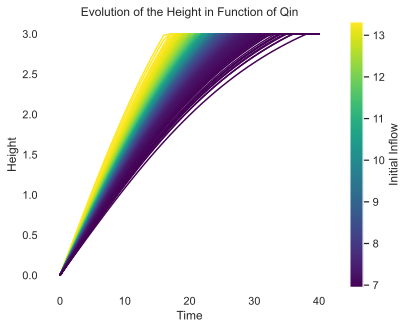

In [9]:
max_t = max( df_time["FinalTime"] )
i_t = list(t).index(max_t)+2

allQ = df[ df["Time"] == 0][["Q", "Dataset"]].sort_values(by="Q")
cmap = plt.get_cmap('viridis')

for maxH in toTest:
    fig, ax = plt.subplots()
    
    Y = df[ df["MaxH"] == maxH ]
    
    for i in reversed(allQ.index):
        X = Y[ Y["Dataset"] == allQ["Dataset"][i] ]
        X = list( X["H"] )
        
        ax.plot( range(len(X[:i_t])), X[:i_t], color = cmap( list(allQ.index).index(i)/len(list(allQ.index)) ))
        
    ax.set_xlabel("Time")
    ax.set_ylabel("Height")
    plt.title(f"Evolution of the Height in Function of Qin")
    
    cb = fig.colorbar(ScalarMappable(norm=Normalize( vmin = list(allQ["Q"])[0],
                                                     vmax = list(allQ["Q"])[-1] ), cmap=cmap), ax=ax)
    cb.set_label('Initial Inflow')
    
    plt.show()

### Discretisation

In [10]:
for i in df.index:
    for v in ["dH","dV","dQ"]:
        if df.loc[i, v] < 0:
            df.loc[i,f"{v}_DIS"] = -1
        elif df.loc[i, v] > 0:
            df.loc[i,f"{v}_DIS"] = 1
        else:
            df.loc[i,f"{v}_DIS"] = 0
            
    if int(df.loc[i,"H"]) == int(df.loc[i, "MaxH"]):
        df.loc[i,"H_DIS"] = 2
        df.loc[i,"V_DIS"] = 2
        df.loc[i,"Q_DIS"] = 0
    else:
        for v in ["H","V","Q"]:
            if df.loc[i,v] != 0:
                df.loc[i,f"{v}_DIS"] = 1
            else:
                df.loc[i,f"{v}_DIS"] = 0
                
df.head()

Time  Time Steps         H        dH         V        dV          Q  \
0  0.000000           1  0.000000  0.186873  0.000000  0.586780  11.624345   
1  0.050505           2  0.186873  0.186286  0.586780  0.584938  11.606070   
2  0.101010           3  0.373159  0.185120  1.171719  0.581277  11.551473   
3  0.151515           4  0.558279  0.183389  1.752996  0.575842  11.461235   
4  0.202020           5  0.741668  0.181115  2.328838  0.568700  11.336475   

         dQ  MaxH    R        Qin  Dataset  dH_DIS  dV_DIS  dQ_DIS  H_DIS  \
0 -0.018275     3  1.0  11.624345        0     1.0     1.0    -1.0    0.0   
1 -0.054597     3  1.0  11.624345        0     1.0     1.0    -1.0    1.0   
2 -0.090237     3  1.0  11.624345        0     1.0     1.0    -1.0    1.0   
3 -0.124761     3  1.0  11.624345        0     1.0     1.0    -1.0    1.0   
4 -0.157762     3  1.0  11.624345        0     1.0     1.0    -1.0    1.0   

   V_DIS  Q_DIS  
0    0.0    1.0  
1    1.0    1.0  
2    1.0    1.0  
3    1.0    1.0  
4    1.0    1.0

### Add States

In [11]:
S2V = {
    "s1": {
        "H":0, "dH":1, "V":0, "dV":1, "Q":1, "dQ":-1
    },
    "s2": {
        "H":1, "dH":1, "V":1, "dV":1, "Q":1, "dQ":-1
    },
    "s3": {
        "H":2, "dH":0, "V":2, "dV":0, "Q":0, "dQ":0
    }
}

V2S = { tuple( [S2V[s][v] for v in ["H", "V", "Q", "dH", "dV", "dQ"]] ):s for s in S2V }

In [12]:
for i in df.index:
    s = tuple([df.loc[i,f"{v}_DIS"] for v in ["H", "V", "Q", "dH", "dV", "dQ"] ])
    try:
        df.loc[i,"STATE t"] = V2S[s]
    except:
        print(i, df.loc[i])
        break
    
df["STATE t+1"] = list( df["STATE t"] )[1:] + [ list( df["STATE t"] )[-1] ]

lastT = df.loc[df.index[-1], "Time"]
df = df.drop(df[df.Time == lastT].index)

df.head()

Time  Time Steps         H        dH         V        dV          Q  \
0  0.000000           1  0.000000  0.186873  0.000000  0.586780  11.624345   
1  0.050505           2  0.186873  0.186286  0.586780  0.584938  11.606070   
2  0.101010           3  0.373159  0.185120  1.171719  0.581277  11.551473   
3  0.151515           4  0.558279  0.183389  1.752996  0.575842  11.461235   
4  0.202020           5  0.741668  0.181115  2.328838  0.568700  11.336475   

         dQ  MaxH    R        Qin  Dataset  dH_DIS  dV_DIS  dQ_DIS  H_DIS  \
0 -0.018275     3  1.0  11.624345        0     1.0     1.0    -1.0    0.0   
1 -0.054597     3  1.0  11.624345        0     1.0     1.0    -1.0    1.0   
2 -0.090237     3  1.0  11.624345        0     1.0     1.0    -1.0    1.0   
3 -0.124761     3  1.0  11.624345        0     1.0     1.0    -1.0    1.0   
4 -0.157762     3  1.0  11.624345        0     1.0     1.0    -1.0    1.0   

   V_DIS  Q_DIS STATE t STATE t+1  
0    0.0    1.0      s1        s2  
1    1.0    1.0      s2        s2  
2    1.0    1.0      s2        s2  
3    1.0    1.0      s2        s2  
4    1.0    1.0      s2        s2

### Add Period

In [13]:
DT = 0
STATE = ""
time = 0

for i in df.index:
    dt = df.loc[i,"MaxH"]
    if dt == DT:
        state = df.loc[i,"STATE t"]
        if STATE == state:
            time += 1
        else:
            STATE = df.loc[i,"STATE t"]
            time = 1
    else:
        DT = df.loc[i,"MaxH"]
        STATE = df.loc[i,"STATE t"]
        time = 1
        
    df.loc[i,"Period t"] = f"t{'0'*(len(str(maxT))-len(str(time)))}{time}"
    
df.head()

Time  Time Steps         H        dH         V        dV          Q  \
0  0.000000           1  0.000000  0.186873  0.000000  0.586780  11.624345   
1  0.050505           2  0.186873  0.186286  0.586780  0.584938  11.606070   
2  0.101010           3  0.373159  0.185120  1.171719  0.581277  11.551473   
3  0.151515           4  0.558279  0.183389  1.752996  0.575842  11.461235   
4  0.202020           5  0.741668  0.181115  2.328838  0.568700  11.336475   

         dQ  MaxH    R  ...  Dataset  dH_DIS  dV_DIS  dQ_DIS  H_DIS  V_DIS  \
0 -0.018275     3  1.0  ...        0     1.0     1.0    -1.0    0.0    0.0   
1 -0.054597     3  1.0  ...        0     1.0     1.0    -1.0    1.0    1.0   
2 -0.090237     3  1.0  ...        0     1.0     1.0    -1.0    1.0    1.0   
3 -0.124761     3  1.0  ...        0     1.0     1.0    -1.0    1.0    1.0   
4 -0.157762     3  1.0  ...        0     1.0     1.0    -1.0    1.0    1.0   

   Q_DIS  STATE t STATE t+1 Period t  
0    1.0       s1        s2     t001  
1    1.0       s2        s2     t001  
2    1.0       s2        s2     t002  
3    1.0       s2        s2     t003  
4    1.0       s2        s2     t004  

[5 rows x 21 columns]

In [14]:
df.to_csv("BDD.csv", sep=";", index=False)

### Period Visualisation

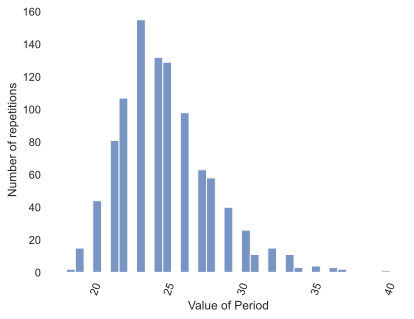

In [15]:
compareDF = df[ df["STATE t"]=="s3" ]
compareDF = compareDF[ compareDF["Period t"]=="t001" ]

compareDF['Period t'] = pd.Categorical(compareDF['Period t'], sorted(list(set(compareDF["Period t"]))))
compareDF['Origin'] = "Truth"

sns.histplot(data=compareDF, x="Time Steps")#, stat="proportion")#, bins = sorted(list(set(temp["Period t"]))))#, hue="MaxH")
plt.xticks(rotation=70)
plt.xlabel("Value of Period")
plt.ylabel("Number of repetitions")
plt.show()

### Learn BNS

In [16]:
# Creates Learning Set
nbDataset = 100 #float('inf')
df = df[ df["Dataset"] < nbDataset ]

In [17]:
# States definition
s2s = { "s1":["s1", "s2"],
        "s2":["s2", "s3"],
        "s3":["s3"]}

A prior is defined to encompass some relations such as: "S1 cannot transition directly to S3".

In [18]:
s = f"STATE t+1{{s1|s2|s3}}<-STATE t{{s1|s2|s3}}->Period t{ '{'+'|'.join( sorted(list(set(df['Period t']))) )+'}'  }->STATE t+1{{s1|s2|s3}}"
str_BN = gum.fastBN(s)
str_BN

(pyAgrum.BayesNet<double>@0x1e2f32a4d10) BN{nodes: 3, arcs: 3, domainSize: 729, dim: 728, mem: 7Ko 632o}

In [19]:
priorBN = gum.fastBN(s)

# Normalize all distributions by default
for v in priorBN.names():
    priorBN.cpt(v).fillWith(1).normalizeAsCPT()
    
# We cannot go from s2 to s1
for p in set(df["Period t"]):
    priorBN.cpt("STATE t+1")[{"Period t":p, "STATE t":"s2"}] = [0,1,1]
    priorBN.cpt("STATE t+1").normalizeAsCPT()
    
# We cannot go from s3 to s2
for p in set(df["Period t"]):
    priorBN.cpt("STATE t+1")[{"Period t":p, "STATE t":"s3"}] = [0,0,1]
    priorBN.cpt("STATE t+1").normalizeAsCPT()
    
# We cannot go from s1 to s3
for p in set(df["Period t"]):
    priorBN.cpt("STATE t+1")[{"Period t":p, "STATE t":"s1"}] = [1,1,0]
    priorBN.cpt("STATE t+1").normalizeAsCPT()

### Learning

In [20]:
models = dict()

for MaxH in toTest:
    X = df[ df["MaxH"] == MaxH ]
    X = X[ ["STATE t", "STATE t+1", "Period t"] ]
    

    learner = gum.BNLearner(X, str_BN)
    learner.addMandatoryArc("STATE t", "STATE t+1")
    learner.addMandatoryArc("STATE t", "Period t")
    learner.addMandatoryArc("Period t", "STATE t+1")

    learner.useScoreAIC()
    learner.useDirichletPrior( priorBN, 1e-3 )

    models[MaxH] = learner.learnBN()
    models[MaxH].cpt("STATE t").normalizeAsCPT()
    models[MaxH].cpt("STATE t+1").normalizeAsCPT()
    models[MaxH].cpt("Period t").normalizeAsCPT()

### Trace Annotated State Graphs

State Graphs can be annotated to show the average transition time between the different states.

In [21]:
# Compute average period for each state
exp = { h:dict() for h in toTest }

for MaxH in toTest:
    maxPeriod = len( models[MaxH].variable("Period t").labels() )
    s_label = models[MaxH].variable("STATE t").labels()
    
    for st0 in s_label:
        ie = gum.LazyPropagation(models[MaxH])
        ie.setEvidence( {"STATE t":st0} )
        ie.makeInference()
        
        cpt = ie.posterior("STATE t+1").tolist()
                
        for i in range(len(s_label)):
            st1 = s_label[i]
            
            if st0 != st1 and cpt[i] > 1e-5:
                
                ie = gum.LazyPropagation(models[MaxH])
                ie.setEvidence( {"STATE t":st0, "STATE t+1":st1} )
                ie.makeInference()

                cpt = ie.posterior("Period t").tolist()
                esp = sum( [ (k+1)*cpt[k] for k in range(maxPeriod) ] )

                if st0 not in exp[MaxH]:
                    exp[MaxH][st0] = dict()

                exp[MaxH][st0][st1] = round(esp)

In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import pylab

def traceGraph( MaxH, exp, title = None ):
    G = nx.DiGraph()
    s_label = models[MaxH].variable("STATE t").labels()

    # Draw found connections
    for st0 in models[MaxH].variable("STATE t").labels():
        
        ie = gum.LazyPropagation(models[MaxH])
        ie.setEvidence( {"STATE t":st0} )
        ie.makeInference()
        
        cpt =ie.posterior("STATE t+1").tolist()
        
        for ip in range(len(cpt)):
            if cpt[ip] > 1e-3:
                
                if st0 != s_label[ip]:
                    w = exp[MaxH][st0][ s_label[ip] ]
                else:
                    w = None
                
                if s_label[ip] in s2s[ st0 ]:
                    color = "black"
                else:
                    color = "red"
                    
                G.add_edge(st0, s_label[ip], color = color, style='solid', weight = w)

    edge_labels = dict()
    edge_labels_bis = dict()
    edge_labels_self = dict()
    for u,v,d in G.edges(data=True):
        if u == v:
            edge_labels_self[(u,v)] = f"{d['weight']}"
        else:
            if (v,u) not in edge_labels:
                if (v,u) in G.edges:
                    otherp = G.edges[(v,u)]['weight']
                    if int(u[1:]) < int(v[1:]):
                        edge_labels[(u,v)] = f"{d['weight']}\n{otherp}"
                    else:
                        edge_labels[(u,v)] = f"{otherp}\n{d['weight']}"
                else:
                    edge_labels[(u,v)] = f"{d['weight']}"

    options = {
        'node_color':'grey',
        'node_size': 300,
        'width': 1,
        'arrowstyle': '-|>',
        'arrowsize': 12,
        'edge_color': [G[u][v]['color'] for u,v in G.edges()],
    }
    
    pos = nx.nx_agraph.graphviz_layout(G, prog = "dot")

    plt.figure(3,figsize=(3,3)) 

    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, label_pos=0.5, font_size = 8)

    nx.draw_networkx(G, pos, **options,  arrows=True)
    
    if title != None:
        plt.title(title)
    
    plt.show()

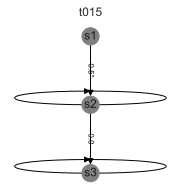

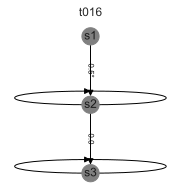

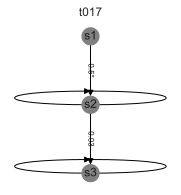

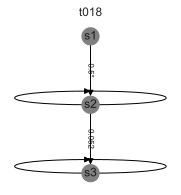

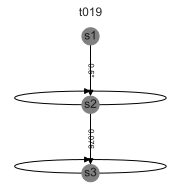

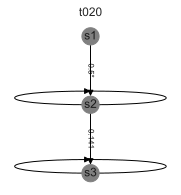

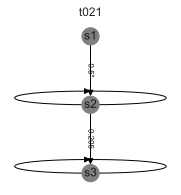

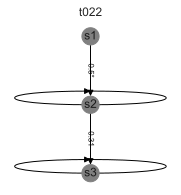

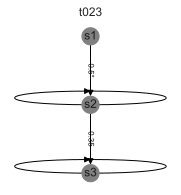

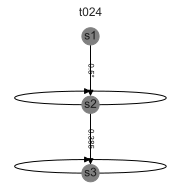

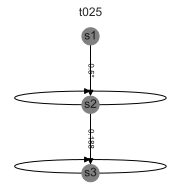

In [23]:
times = dict()

for t in range(15,26):
    period = f"t{'0'*(3-len(str(t)))}{t}"
    times[period] = {}

    for MaxH in toTest:
        times[period][MaxH] = dict()

        for st0 in s_label:
            times[period][MaxH][st0] = dict()

            ie = gum.LazyPropagation(models[MaxH])
            ie.setEvidence( {"STATE t":st0, "Period t":period} )
            ie.makeInference()

            cpt = ie.posterior("STATE t+1").tolist()
            
            # Check whether the dabase gave information or not
            ie = gum.LazyPropagation(priorBN)
            ie.setEvidence( {"STATE t":st0, "Period t":period} )
            ie.makeInference()
            
            if cpt == ie.posterior("STATE t+1").tolist():
                s = "*"
            else:
                s = ""

            for i in range(len(s_label)):
                st1 = s_label[i]
                
                times[period][MaxH][st0][st1] = f"{round(cpt[i],3)}{s}"

        traceGraph( 3, times[period], title = period )

### Multiple graphs

In [24]:
models[3].cpt("STATE t+1")

(pyAgrum.Potential<double>@0x1e2f335c0d0) 
             ||  STATE t+1                  |
STATE |Period||s1       |s2       |s3       |
------|------||---------|---------|---------|
s1    |t001  || 0.0000  | 1.0000  | 0.0000  |
s2    |t001  || 0.0000  | 1.0000  | 0.0000  |
s3    |t001  || 0.0000  | 0.0000  | 1.0000  |
s1    |t002  || 0.5000  | 0.5000  | 0.0000  |
s2    |t002  || 0.0000  | 1.0000  | 0.0000  |
s3    |t002  || 0.0000  | 0.0000  | 1.0000  |
[...231 more line(s) ...]
s1    |t080  || 0.5000  | 0.5000  | 0.0000  |
s2    |t080  || 0.0000  | 0.5000  | 0.5000  |
s3    |t080  || 0.0000  | 0.0000  | 1.0000  |
s1    |t081  || 0.5000  | 0.5000  | 0.0000  |
s2    |t081  || 0.0000  | 0.5000  | 0.5000  |
s3    |t081  || 0.0000  | 0.0000  | 1.0000  |

We know State t and State t+1.

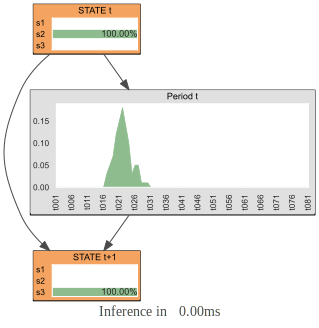

In [25]:
gnb.showInference( models[3], evs={"STATE t":"s2", "STATE t+1":"s3"} )

We know that State t is either s1 or s2, and State t+1 is either s2 or s3.

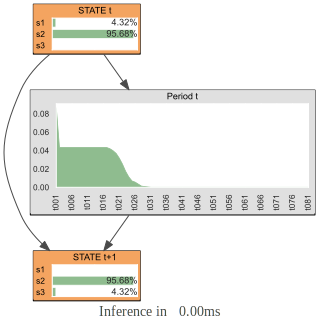

In [26]:
gnb.showInference( models[3], evs={"STATE t":[1,1,0], "STATE t+1":[0,1,1]} )

We know we have been in the same state for 15 time steps.

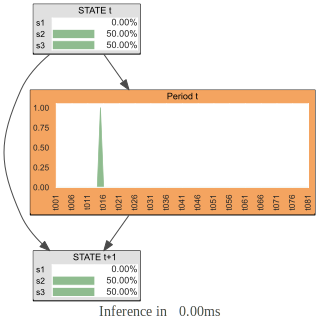

In [27]:
gnb.showInference( models[3], evs={"Period t":"t015"} )

## Comparison to Naive BNs
### Guided Approach
#### Learning

In [28]:
X = df[ ['H', 'V', 'Q', 'Time Steps', 'Dataset'] ]

Xd = { f"{c} t":[] for c in ['H', 'V', 'Q'] }
for c in ['H', 'V', 'Q']:
    for ds in set(X["Dataset"]):
        Xds = X[ X["Dataset"]==ds ]
        
        minV, maxV = min(Xds[c]), max(Xds[c])
        out, bins = pd.cut(Xds[c], 3, retbins=True)
        for i in Xds.index:
            if Xds.loc[i,c] == minV:
                Xd[f"{c} t"].append("0")
            elif Xds.loc[i,c] == maxV and c != "Q":
                Xd[f"{c} t"].append("Max")
            else:
                Xd[f"{c} t"].append("+")

Xd = pd.DataFrame( Xd )
Xd["Dataset"] = list(X["Dataset"])
Xd["Time Steps"] = [ f"t{i}" for i in list(X["Time Steps"]) ]

In [29]:
# Time
todrop = list()
for i in Xd.index[:-1]:
    dt = Xd.loc[i, "Dataset"]
    if Xd.loc[i+1,"Dataset"] == dt:
        for c in ['H', 'V', 'Q']:
            Xd.loc[i,f"{c} t+1"] = Xd.loc[i+1,f"{c} t"]
    else:
        todrop.append(i)
        
todrop.append(Xd.index[-1])
Xd = Xd.drop(todrop)
Xd = Xd.drop("Dataset", axis=1)

In [30]:
learner = gum.BNLearner( Xd )

learner.setSliceOrder( [["V t", "H t", "Q t", "Time Steps"], ["V t+1", "H t+1", "Q t+1"]] )

arcs = [('Q t', 'V t'), ('V t','H t'), ('H t', 'Q t+1'), ('Q t+1','V t+1'), ('V t+1', 'H t+1'),
        ('Q t', 'Q t+1'), ('V t', 'V t+1'), ('H t', 'H t+1'),
        ("Time Steps","Q t"), ("Time Steps","V t"), ("Time Steps","H t"),
        ("Time Steps","Q t+1"), ("Time Steps","V t+1"), ("Time Steps","H t+1")]
for e,s in arcs:
    learner.addMandatoryArc(e,s)

learner.useScoreAIC()
learner.useSmoothingPrior(1e-10)

str_naive = learner.learnBN()

str_naive

(pyAgrum.BayesNet<double>@0x1e2f3371f40) BN{nodes: 7, arcs: 14, domainSize: 14112, dim: 2939, mem: 41Ko 352o}

#### Simulation

In [31]:
def simulNaive( v0, h0, q0, t, model = str_naive ):
    ie = gum.LazyPropagation(model)
    ie.setEvidence( {"V t":v0, "H t":h0, "Q t":q0, "Time Steps":t} )
    ie.makeInference()
    
    return( { x:ie.posterior(x).tolist() for x in ["V t+1", "H t+1", "Q t+1"] }  )

In [32]:
values0 = dict()
for var in ["V t", "H t", "Q t"]:
    values0[var] = list(str_naive.variable(var).labels())

In [33]:
valuest = dict()
for var in ["V t+1", "H t+1", "Q t+1"]:
    valuest[var] = list(str_naive.variable(var).labels())

In [34]:
all_sim_0 = list()

for rep in range(1000):
    v = { "V":'0', "H":'0',  "Q":"+", "Time Steps":"t1"  }
    lp = [ [ v["V"], v["H"], v["Q"], v["Time Steps"] ] ]
    
    while v["H"] != "Max" and len(lp)<100:
        cpt = simulNaive( v["V"], v["H"], v["Q"], v["Time Steps"] )
        
        for var in ["V", "H", "Q"]:
            v[var] = rd.choice( valuest[f"{var} t+1"], p = cpt[f"{var} t+1"] )
            
        time = len(lp)+1
        v["Time Steps"] = f"t{time}"
        lp.append( [ v["V"], v["H"], v["Q"], v["Time Steps"] ] )
        
    
    all_sim_0.append( lp )

In [35]:
RES = pd.DataFrame({ "Time Steps":[ len(lp) if len(lp)<100 else -1 for lp in all_sim_0 ] })
RES["Origin"] = "Guided"

df_compare = pd.concat( [ RES, compareDF[["Period t", "Time Steps", "Origin"]] ], ignore_index=True )

### Unguided Approach
#### Learning

In [36]:
X = df[ ['H', 'V', 'Q', 'Time Steps', 'Dataset'] ]

Xd = { f"{c} t":[] for c in ['H', 'V', 'Q'] }
for c in ['H', 'V', 'Q']:
    out, bins = pd.cut(X[c], 5, retbins=True)
    Xd[f"{c} t"] = [ str(i) for i in out ]
    
values = list( X["H"] )
for i in range(len(values)):
    if values[i] > 3:
        Xd["H t"][i] = "Max"
        Xd["V t"][i] = "Max"
    elif values[i] == 0:
        Xd["H t"][i] = "0"
        Xd["V t"][i] = "0"

Xd = pd.DataFrame( Xd )
Xd["Dataset"] = list(X["Dataset"])
Xd["Time Steps"] = [ f"t{i}" for i in list(X["Time Steps"]) ]

In [37]:
# Time
todrop = list()
for i in Xd.index[:-1]:
    dt = Xd.loc[i, "Dataset"]
    if Xd.loc[i+1,"Dataset"] == dt:
        for c in ['H', 'V', 'Q']:
            Xd.loc[i,f"{c} t+1"] = Xd.loc[i+1,f"{c} t"]
    else:
        todrop.append(i)
        
todrop.append(Xd.index[-1])
Xd = Xd.drop(todrop)
Xd = Xd.drop("Dataset", axis=1)

In [38]:
learner = gum.BNLearner( Xd )

learner.setSliceOrder( [["Time Steps"], ["V t", "H t", "Q t"], ["V t+1", "H t+1", "Q t+1"]] )

learner.useScoreAIC()
learner.useSmoothingPrior(1e-10)

naive = learner.learnBN()

naive

(pyAgrum.BayesNet<double>@0x1e2fb5b8830) BN{nodes: 7, arcs: 7, domainSize: 10^6.63566, dim: 940, mem: 8Ko 576o}

#### Simulation

In [39]:
values0 = dict()
for var in ["V t", "H t", "Q t"]:
    values0[var] = list(naive.variable(var).labels())

In [40]:
valuest = dict()
for var in ["V t+1", "H t+1", "Q t+1", "Time Steps"]:
    valuest[var] = list(naive.variable(var).labels())

In [41]:
all_sim1 = list()

for rep in range(1000):
    v = { "V":values0["V t"][-2], "H":values0["H t"][-2],  "Q":values0["Q t"][-1], "Time Steps":"t1"  }
    lp = [ [ v["V"], v["H"], v["Q"], v["Time Steps"] ] ]
    
    while v["H"] != valuest["H t+1"][-1] and len(lp)<99:
        cpt = simulNaive( v["V"], v["H"], v["Q"], v["Time Steps"], model = naive )
        
        for var in ["V", "H", "Q"]:
            v[var] = rd.choice( valuest[f"{var} t+1"], p = cpt[f"{var} t+1"] )
            
        time = len(lp)+1
        v["Time Steps"] = f"t{time}"
        lp.append( [ v["V"], v["H"], v["Q"], v["Time Steps"] ] )

    all_sim1.append( lp )

In [42]:
RES = pd.DataFrame({ "Time Steps":[ len(lp) if len(lp)<100 else -1 for lp in all_sim1 ] })
RES["Origin"] = "Unguided"

df_compare = pd.concat( [ RES, df_compare[["Period t", "Time Steps", "Origin"]] ], ignore_index=True )

### Combined - Simulation

In [43]:
result = {  }
for k in range(1000):
    st0= "s1"
    time = 1
    timePeriod = 1
    simul = [ st0 ]
    
    while st0 != "s3":
        period = f"t{'0'*(len(str(maxT))-len(str(timePeriod)))}{timePeriod}"
        cpt = models[3].cpt("STATE t+1")[{"STATE t":st0, "Period t":period}]
        s = rd.choice( ["s1", "s2", "s3"], p = cpt )
        
        if st0 == s:
            timePeriod += 1
        else:
            st0 = s
            timePeriod = 1
        time += 1
        simul.append(s)
        
    result[k] = ( period, simul, time )

RES = pd.DataFrame(  {"Period t": [ result[k][0] for k in result ], "Time Steps": [ result[k][-1] for k in result ]}  )
RES['Period t'] = pd.Categorical(RES['Period t'], sorted(list(set(RES["Period t"]))))
RES["Time Steps"] = pd.Categorical(RES["Time Steps"], sorted(list(set(RES["Time Steps"]))))
RES["Origin"] = "Combined"

df_compare = pd.concat( [ RES, df_compare[["Period t", "Time Steps", "Origin"]] ], ignore_index=True )
df_compare["Time Steps"] = pd.Categorical(df_compare["Time Steps"], sorted(list(set(df_compare["Time Steps"]))))

### Graphs

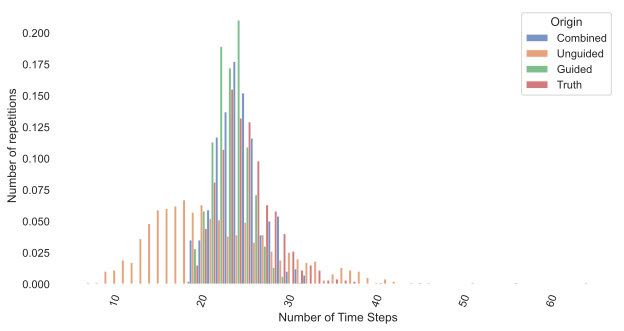

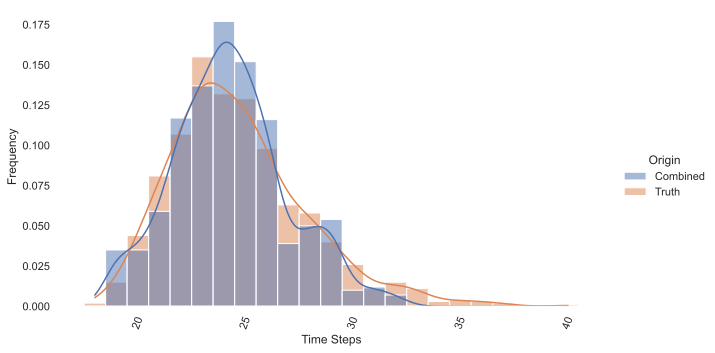

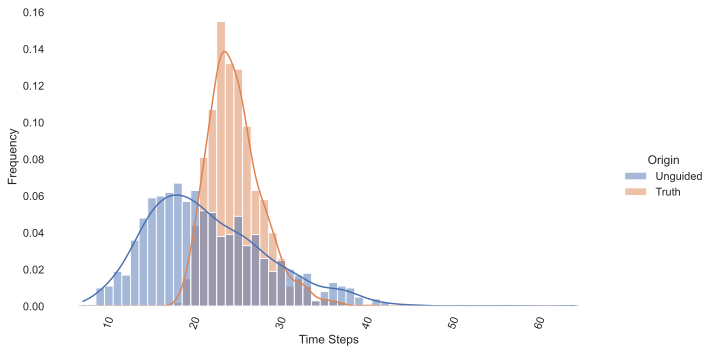

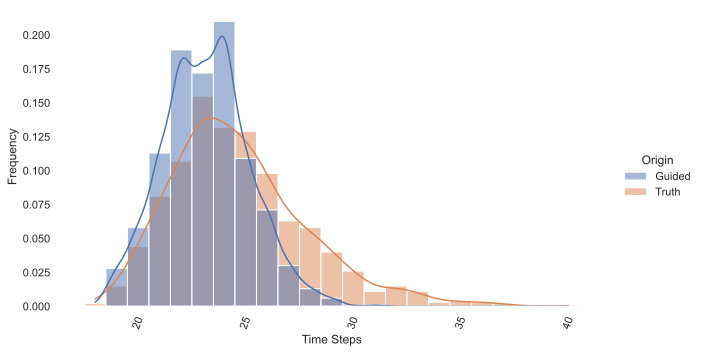

In [44]:
df_test = df_compare[ df_compare["Origin"] != "STR-Naive" ]

plt.figure(3,figsize=(10,5)) 
sns.histplot(data=df_compare, x="Time Steps", hue="Origin", common_norm=False, stat="proportion", multiple="dodge")
plt.xticks(rotation=70)
plt.xlabel("Number of Time Steps")
plt.ylabel("Number of repetitions")
plt.show()

for k in [ "Combined", "Unguided", "Guided" ]:
    df_test = df_compare[ df_compare["Origin"].isin(["Truth", k]) ]
    
    g = sns.displot(data=df_test, x="Time Steps", hue="Origin", stat = "proportion", common_norm=False, element="bars", kde=True, aspect=1.75)
    
    plt.xticks(rotation=70)
    plt.xlabel("Time Steps")
    plt.ylabel("Frequency")
    plt.show()

### Trace

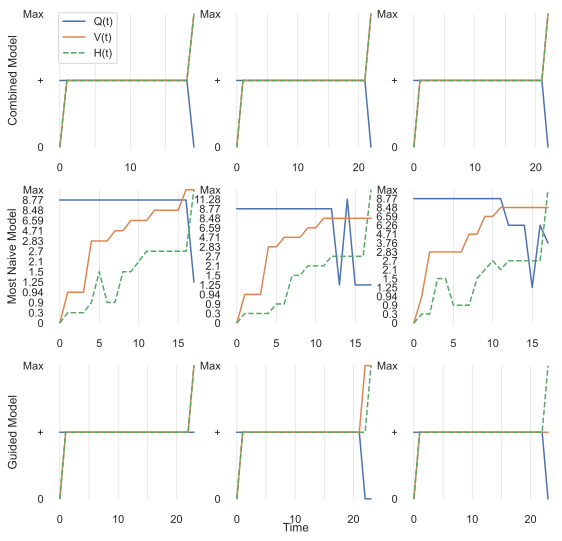

In [45]:
N = 3

fig, axs = plt.subplots(3, N, figsize=(9,9))  

# Combined model
i, t_target, done = 0, 24, set()
for rep in range(N):
    q, v, h = list(), list(), list()
    
    while len(result[i]) != t_target or i in done:
        i += 1
        if i == len(result):
            t_target -= 1
            i = 0
    done.add(i)
    
    for s in result[i][1]:    
        if s == "s1":
            q.append(1)
            v.append(0)
            h.append(0)
        elif s == "s2":
            q.append(1)
            v.append(1)
            h.append(1)
        elif s == "s3":
            q.append(0)
            v.append(2)
            h.append(2)
            
    ticks = ["0", "+", "Max"]
    axs[0,rep].set_yticks([0,1,2], labels=ticks)
    
    xlimits = [ k for k in range(len(q)) if k%5==0 ]
    for k in xlimits:
        axs[0,rep].plot( [k,k], [0, len(ticks)-1], c='lightgray', lw=0.5 )
    
    axs[0,rep].plot( range(len(q)), q, label="Q(t)" )
    axs[0,rep].plot( range(len(v)), v, label="V(t)" )
    axs[0,rep].plot( range(len(h)), h, '--', label="H(t)" )
    
# Naive model
i, t_target, done = 0, 18, set()
for rep in range(N):
    
    while len(all_sim1[i]) != t_target or i in done:
        i += 1
        if i == len(all_sim1):
            t_target -= 1
    done.add(i)
    
    lp = np.array( all_sim1[i] )
    
    v, h, q = list(lp[:,0]), list(lp[:,1]), list(lp[:,2])
    
    allVal = set()
    for l in [q,v,h]:
        for i in range(len(l)):
            if l[i] not in ["0", "Max"]:
                val = round(sum([float(k) for k in l[i][1:-1].split(", ")])/2,2)
                l[i] = val
                allVal.add(val)
    ticks = ["0"] + sorted(list(allVal)) + ["Max"]
    ticks = [ str(i) for i in ticks ]
    
    for l in [q,v,h]:
        for i in range(len(l)):
            l[i] = ticks.index(str(l[i]))
            l[i] = int(l[i])
    
    axs[1,rep].set_yticks(list(range(len(ticks))), labels=ticks)
    
    xlimits = [ k for k in range(len(q)) if k%5==0 ]
    for k in xlimits:
        axs[1,rep].plot( [k,k], [0, len(ticks)-1], c='lightgray', lw=0.5 )
    
    axs[1,rep].plot( range(len(q)), q, label="Q(t)" )
    axs[1,rep].plot( range(len(v)), v, label="V(t)" )
    axs[1,rep].plot( range(len(h)), h, '--', label="H(t)" )
    
# Guided model
i, t_target, done = 0, 24, set()
for rep in range(N):
    
    while len(all_sim_0[i]) != t_target or i in done:
        i += 1
        if i == len(all_sim_0):
            t_target -= 1
    done.add(i)
    
    lp = np.array( all_sim_0[i] )
    
    v, h, q = list(lp[:,0]), list(lp[:,1]), list(lp[:,2])
    
    ticks = ["0", "+", "Max"]
    
    for l in [q,v,h]:
        for i in range(len(l)):
            l[i] = ticks.index(str(l[i]))
            l[i] = int(l[i])
    
    axs[2,rep].set_yticks(list(range(len(ticks))), labels=ticks)
    
    xlimits = [ k for k in range(len(q)) if k%5==0 ]
    for k in xlimits:
        axs[2,rep].plot( [k,k], [0, len(ticks)-1], c='lightgray', lw=0.5 )
    
    axs[2,rep].plot( range(len(q)), q, label="Q(t)" )
    axs[2,rep].plot( range(len(v)), v, label="V(t)" )
    axs[2,rep].plot( range(len(h)), h, '--', label="H(t)" )
    
fig.patch.set_facecolor('white')
axs[0,0].set_ylabel("Combined Model")
axs[1,0].set_ylabel("Most Naive Model")
axs[2,0].set_ylabel("Guided Model")
   
axs[0,0].legend(loc='upper left')    

fig.text(0.5, 0.07, 'Time', ha='center')

plt.show()

### Evaluation

In [46]:
from collections import Counter

final_res = dict()
counters = dict()

for ori in set(df_compare["Origin"]):
    counters[ori] = Counter(df_compare[ df_compare["Origin"]==ori ]["Time Steps"])

for c in set(df_compare["Time Steps"]):
    
    if c != -1:
        final_res[c] = dict()
        for ori in counters:
            if c in counters[ori]:
                final_res[c][ori] = counters[ori][c]
            else:
                final_res[c][ori] = 1e-50
            
for c in final_res:
    for ori in final_res[c]:
        final_res[c][ori] /= len( df_compare[ df_compare["Origin"]==ori ] )

#### Likelihood

In [47]:
for ori in ["Truth","Combined", "Unguided", "Guided"]:
    esp = sum( [ k*final_res[k][ori] for k in final_res ] )
    print(ori, esp)

Truth 24.675000000000004
Combined 24.308
Unguided 21.589000000000006
Guided 23.169


#### Kolmogorov-Smirnov

In [48]:
import numpy as np
from scipy.stats import ks_2samp

x = [ final_res[l]["Truth"] for l in sorted(final_res.keys())]

for ori in ["Combined", "Unguided", "Guided"]:
    y = [ final_res[l][ori] for l in sorted(final_res.keys())]

    print( ori, ks_2samp(x, y, method='exact') )

Combined KstestResult(statistic=0.16666666666666666, pvalue=0.6099552607672825, statistic_location=1e-53, statistic_sign=-1)
Unguided KstestResult(statistic=0.5, pvalue=3.8976747105695574e-05, statistic_location=1e-53, statistic_sign=1)
Guided KstestResult(statistic=0.21428571428571427, pvalue=0.2923622020767289, statistic_location=1e-53, statistic_sign=-1)
